In [74]:
import os
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from utils.timefeatures import time_features
# from data_provider.m4 import M4Dataset, M4Meta
# from data_provider.uea import subsample, interpolate_missing, Normalizer
# from sktime.datasets import load_from_tsfile_to_dataframe
import warnings
# from utils.augmentation import run_augmentation_single

warnings.filterwarnings('ignore')

In [5]:
from data_provider.data_factory import data_provider

In [ ]:
data_set, data_loader = data_provider()

## PSM

In [93]:
class PSMSegLoader(Dataset):
    def __init__(self, root_path, win_size, step=1, flag="train"):
        self.flag = flag
        self.step = step
        self.win_size = win_size
        self.scaler = StandardScaler()
        data = pd.read_csv(os.path.join(root_path, 'train.csv'))
        data = data.values[:, 1:]
        data = np.nan_to_num(data)
        self.scaler.fit(data)
        data = self.scaler.transform(data)
        test_data = pd.read_csv(os.path.join(root_path, 'test.csv'))
        test_data = test_data.values[:, 1:]
        test_data = np.nan_to_num(test_data)
        self.test = self.scaler.transform(test_data)
        self.train = data
        data_len = len(self.train)
        self.val = self.train[(int)(data_len * 0.8):]
        self.test_labels = pd.read_csv(os.path.join(root_path, 'test_label.csv')).values[:, 1:]
        print("test:", self.test.shape)
        print("train:", self.train.shape)

    def __len__(self):
        if self.flag == "train":
            return (self.train.shape[0] - self.win_size) // self.step + 1
        elif (self.flag == 'val'):
            return (self.val.shape[0] - self.win_size) // self.step + 1
        elif (self.flag == 'test'):
            return (self.test.shape[0] - self.win_size) // self.step + 1
        else:
            return (self.test.shape[0] - self.win_size) // self.win_size + 1

    def __getitem__(self, index):
        index = index * self.step
        if self.flag == "train":
            return np.float32(self.train[index:index + self.win_size]), np.float32(self.test_labels[0:self.win_size])
        elif (self.flag == 'val'):
            return np.float32(self.val[index:index + self.win_size]), np.float32(self.test_labels[0:self.win_size])
        elif (self.flag == 'test'):
            return np.float32(self.test[index:index + self.win_size]), np.float32(
                self.test_labels[index:index + self.win_size])
        else:
            return np.float32(self.test[
                              index // self.step * self.win_size:index // self.step * self.win_size + self.win_size]), np.float32(
                self.test_labels[index // self.step * self.win_size:index // self.step * self.win_size + self.win_size])



class Dataset_Custom(Dataset):
    def __init__(self, root_path, flag='train', size=None,
                 features='S', data_path='ETTh1.csv',
                 target='OT', scale=True, timeenc=0, freq='h', seasonal_patterns=None):
        # size [seq_len, label_len, pred_len]
        # self.args = args
        # info
        if size == None:
            self.seq_len = 24 * 4 * 4
            self.label_len = 24 * 4
            self.pred_len = 24 * 4
        else:
            self.seq_len = size[0]
            self.label_len = size[1]
            self.pred_len = size[2]
        # init
        assert flag in ['train', 'test', 'val']
        type_map = {'train': 0, 'val': 1, 'test': 2}
        self.set_type = type_map[flag]

        self.features = features
        self.target = target
        self.scale = scale
        self.timeenc = timeenc
        self.freq = freq

        self.root_path = root_path
        self.data_path = data_path
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = pd.read_csv(os.path.join(self.root_path,
                                          self.data_path))

        '''
        df_raw.columns: ['date', ...(other features), target feature]
        '''
        cols = list(df_raw.columns)
        cols.remove(self.target)
        cols.remove('date')
        df_raw = df_raw[['date'] + cols + [self.target]]
        num_train = int(len(df_raw) * 0.7)
        num_test = int(len(df_raw) * 0.2)
        num_vali = len(df_raw) - num_train - num_test
        border1s = [0, num_train - self.seq_len, len(df_raw) - num_test - self.seq_len]
        border2s = [num_train, num_train + num_vali, len(df_raw)]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]

        if self.features == 'M' or self.features == 'MS':
            cols_data = df_raw.columns[1:]
            df_data = df_raw[cols_data]
        elif self.features == 'S':
            df_data = df_raw[[self.target]]

        if self.scale:
            train_data = df_data[border1s[0]:border2s[0]]
            self.scaler.fit(train_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values

        df_stamp = df_raw[['date']][border1:border2]
        df_stamp['date'] = pd.to_datetime(df_stamp.date)
        if self.timeenc == 0:
            df_stamp['month'] = df_stamp.date.apply(lambda row: row.month, 1)
            df_stamp['day'] = df_stamp.date.apply(lambda row: row.day, 1)
            df_stamp['weekday'] = df_stamp.date.apply(lambda row: row.weekday(), 1)
            # df_stamp['hour'] = df_stamp.date.apply(lambda row: row.hour, 1)
            data_stamp = df_stamp.drop(['date'], 1).values
        elif self.timeenc == 1:
            data_stamp = time_features(pd.to_datetime(df_stamp['date'].values), freq=self.freq)
            data_stamp = data_stamp.transpose(1, 0)

        self.data_x = data[border1:border2]
        self.data_y = data[border1:border2]

        # if self.set_type == 0 and self.args.augmentation_ratio > 0:
        #     self.data_x, self.data_y, augmentation_tags = run_augmentation_single(self.data_x, self.data_y, self.args)

        self.data_stamp = data_stamp

    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]

        return seq_x, seq_y, seq_x_mark, seq_y_mark

    def __len__(self):
        return len(self.data_x) - self.seq_len - self.pred_len + 1

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)
    
class Dataset_Custom2(Dataset):
    def __init__(self, root_path, flag='train', size=None,
                features='S', data_path='ETTh1.csv',
                target='OT', scale=True, timeenc=0, freq='h', seasonal_patterns=None):
        # size [seq_len, label_len, pred_len]
        # info
        if size == None:
            self.seq_len = 24 * 4 * 4
            self.label_len = 24 * 4
            self.pred_len = 24 * 4
        else:
            self.seq_len = size[0]
            self.label_len = size[1]
            self.pred_len = size[2]
        # init
        assert flag in ['train', 'test', 'val']
        type_map = {'train': 0, 'val': 1, 'test': 2}
        self.set_type = type_map[flag]

        self.features = features
        self.target = target
        self.scale = scale
        self.timeenc = timeenc
        self.freq = freq

        self.root_path = root_path
        self.data_path = data_path
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = pd.read_csv(os.path.join(self.root_path,
                                          self.data_path))

        '''
        df_raw.columns: ['date', ...(other features), target feature]
        '''
        # cols = list(df_raw.columns)
        # cols.remove(self.target)
        # cols.remove('date')
        # df_raw = df_raw[['date'] + cols + [self.target]]
        # df_raw = np.nan_to_num(df_raw.values)
        num_train = int(len(df_raw) * 0.7)
        num_test = int(len(df_raw) * 0.2)
        num_vali = len(df_raw) - num_train - num_test
        border1s = [0, num_train - self.seq_len, len(df_raw) - num_test - self.seq_len]
        border2s = [num_train, num_train + num_vali, len(df_raw)]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]

        if self.features == 'M' or self.features == 'MS':
            cols_data = df_raw.columns[1:]
            df_data = df_raw[cols_data]
        elif self.features == 'S':
            df_data = df_raw[[self.target]]

        if self.scale:
            train_data = df_data[border1s[0]:border2s[0]]
            self.scaler.fit(train_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values

        # df_stamp = df_raw[['date']][border1:border2]
        # df_stamp['date'] = pd.to_datetime(df_stamp.date)
        # if self.timeenc == 0:
        #     df_stamp['month'] = df_stamp.date.apply(lambda row: row.month, 1)
        #     df_stamp['day'] = df_stamp.date.apply(lambda row: row.day, 1)
        #     df_stamp['weekday'] = df_stamp.date.apply(lambda row: row.weekday(), 1)
        #     df_stamp['hour'] = df_stamp.date.apply(lambda row: row.hour, 1)
        #     data_stamp = df_stamp.drop(['date'], 1).values
        # elif self.timeenc == 1:
        #     data_stamp = time_features(pd.to_datetime(df_stamp['date'].values), freq=self.freq)
        #     data_stamp = data_stamp.transpose(1, 0)

        self.data_x = data[border1:border2]
        self.data_y = data[border1:border2]
        # self.data_stamp = data_stamp
    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        # seq_y = self.data_y[r_begin:r_end]
        # seq_x_mark = self.data_stamp[s_begin:s_end]
        # seq_y_mark = self.data_stamp[r_begin:r_end]

        return np.float64(seq_x)
    
    def __len__(self):
        return len(self.data_x) - self.seq_len - self.pred_len + 1

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)



In [65]:
data = pd.read_csv(os.path.join('./dataset/PSM', 'train.csv'))
data = data.values[:, 1:]

In [66]:
data

array([[0.73268938, 0.76174757, 0.60684801, ..., 0.48183813, 0.00653595,
        0.13824885],
       [0.73279883, 0.76185454, 0.60713322, ..., 0.47721826, 0.00653595,
        0.11520737],
       [0.73293796, 0.76159374, 0.60689517, ..., 0.49262264, 0.0087146 ,
        0.0921659 ],
       ...,
       [0.7753667 , 0.90909588, 0.60640893, ..., 0.15241244, 0.0087146 ,
        0.11981567],
       [0.77538344, 0.90918947, 0.60644111, ..., 0.1534086 , 0.0087146 ,
        0.10138249],
       [0.77537391, 0.90918513, 0.60670411, ..., 0.1733751 , 0.0087146 ,
        0.10599078]])

In [94]:
data_dict = {
    'PSM': PSMSegLoader,
    'custom' : Dataset_Custom,
    'custom2' : Dataset_Custom2
}


def data_provider(flag):
    Data = data_dict['PSM']
    timeenc = 1

    shuffle_flag = False if (flag == 'test' or flag == 'TEST') else True
    drop_last = False
    batch_size = 128
    freq = 'h'

    drop_last = False
    data_set = Data(
        root_path='./dataset/PSM',
        win_size=100,
        flag=flag,
    )
    print(flag, len(data_set))
    data_loader = DataLoader(
        data_set,
        batch_size=batch_size,
        shuffle=shuffle_flag,
        num_workers=10,
        drop_last=drop_last)
    return data_set, data_loader

def data_provider_2(flag) :
    Data = data_dict['custom2']
    timeenc = 1

    shuffle_flag = False if (flag == 'test' or flag == 'TEST') else True
    drop_last = False
    batch_size = 128
    freq = 'D'

    drop_last = False
    data_set = Data(
        # args = args,
        root_path='./dataset/ANAM',
        data_path='Normal.csv',
        features='MS',
        target='Cumul_precipitation',
        size = (1, 0, 0),
        flag=flag,
        timeenc=0,
        scale = False
    )
    print(flag, len(data_set))
    data_loader = DataLoader(
        data_set,
        batch_size=batch_size,
        shuffle=True,
        num_workers=10,
        drop_last=drop_last)
    return data_set, data_loader



In [78]:
train_data, train_loader = data_provider('train')

test: (87841, 25)
train: (132481, 25)
train 132382


In [79]:
test_labels = []
for i, (batch_x, batch_y) in enumerate(train_loader) :
    print(batch_x.shape, batch_y.shape)
    if i == 0:
        x, y = batch_x, batch_y
    # elif i == 10:    
    #     break
    test_labels.append(batch_y)

torch.Size([128, 100, 25]) torch.Size([128, 100, 1])
torch.Size([128, 100, 25]) torch.Size([128, 100, 1])
torch.Size([128, 100, 25]) torch.Size([128, 100, 1])
torch.Size([128, 100, 25]) torch.Size([128, 100, 1])
torch.Size([128, 100, 25]) torch.Size([128, 100, 1])
torch.Size([128, 100, 25]) torch.Size([128, 100, 1])
torch.Size([128, 100, 25]) torch.Size([128, 100, 1])
torch.Size([128, 100, 25]) torch.Size([128, 100, 1])
torch.Size([128, 100, 25]) torch.Size([128, 100, 1])
torch.Size([128, 100, 25]) torch.Size([128, 100, 1])
torch.Size([128, 100, 25]) torch.Size([128, 100, 1])
torch.Size([128, 100, 25]) torch.Size([128, 100, 1])
torch.Size([128, 100, 25]) torch.Size([128, 100, 1])
torch.Size([128, 100, 25]) torch.Size([128, 100, 1])
torch.Size([128, 100, 25]) torch.Size([128, 100, 1])
torch.Size([128, 100, 25]) torch.Size([128, 100, 1])
torch.Size([128, 100, 25]) torch.Size([128, 100, 1])
torch.Size([128, 100, 25]) torch.Size([128, 100, 1])
torch.Size([128, 100, 25]) torch.Size([128, 10

In [48]:
x

tensor([[[1., 0., 0.,  ..., 0., 0., 0.]],

        [[2., 0., 0.,  ..., nan, nan, nan]],

        [[3., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[2., 0., 0.,  ..., nan, nan, nan]],

        [[3., 0., 0.,  ..., 0., 0., 0.]],

        [[4., 0., 0.,  ..., 0., 0., nan]]], dtype=torch.float64)

In [58]:
df= pd.read_csv(os.path.join('./dataset/ANAM', 'Normal.csv'))
# df = np.nan_to_num(df.values)

In [59]:
np.nan_to_num(df.values[:,1:])

array([[1, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       [2, 0.0, 0.0, ..., nan, nan, nan],
       [3, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       ...,
       [2, 0.0, 0.0, ..., nan, nan, nan],
       [3, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       [4, 0.0, 0.0, ..., 0.0, 0.0, nan]], dtype=object)

In [65]:
test_labels = np.concatenate(test_labels, axis=0).reshape(-1)
test_labels = np.array(test_labels)

In [18]:
len(test_labels)

4

In [95]:
train_data, train_loader = data_provider_2('train')

train 515


In [97]:
for i, (batch_x) in enumerate(train_loader):
    print(batch_x.shape)
    if i == 10:
        break
    if i == 1:
        t = batch_x

torch.Size([128, 1, 32])
torch.Size([128, 1, 32])
torch.Size([128, 1, 32])
torch.Size([128, 1, 32])
torch.Size([3, 1, 32])


In [96]:
for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(train_loader):
    print(batch_x.shape, batch_y.shape, batch_x_mark.shape, batch_y_mark.shape)
    if i == 10:
        break
    if i == 1:
        t = batch_x


ValueError: too many values to unpack (expected 4)

In [104]:
t[0].shape

torch.Size([100, 1])

In [8]:
from data_provider.data_factory import data_provider
from exp.exp_basic import Exp_Basic
from utils.tools import EarlyStopping, adjust_learning_rate, adjustment
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
import torch.multiprocessing

torch.multiprocessing.set_sharing_strategy('file_system')
import torch
import torch.nn as nn
from torch import optim
import os
import time
import warnings
import numpy as np

warnings.filterwarnings('ignore')


class Exp_Anomaly_Detection(Exp_Basic):
    def __init__(self, args):
        super(Exp_Anomaly_Detection, self).__init__(args)

    def _build_model(self):
        model = self.model_dict[self.args.model].Model(self.args).float()

        if self.args.use_multi_gpu and self.args.use_gpu:
            model = nn.DataParallel(model, device_ids=self.args.device_ids)
        return model

    def _get_data(self, flag):
        data_set, data_loader = data_provider(self.args, flag)
        return data_set, data_loader

    def _select_optimizer(self):
        model_optim = optim.Adam(self.model.parameters(), lr=self.args.learning_rate)
        return model_optim

    def _select_criterion(self):
        criterion = nn.MSELoss()
        return criterion

    def vali(self, vali_data, vali_loader, criterion):
        total_loss = []
        self.model.eval()
        with torch.no_grad():
            for i, (batch_x, _) in enumerate(vali_loader):
                batch_x = batch_x.float().to(self.device)

                outputs = self.model(batch_x, None, None, None)

                f_dim = -1 if self.args.features == 'MS' else 0
                outputs = outputs[:, :, f_dim:]
                pred = outputs.detach()
                true = batch_x.detach()

                loss = criterion(pred, true)
                total_loss.append(loss.item())
        total_loss = np.average(total_loss)
        self.model.train()
        return total_loss

    def train(self, setting):
        train_data, train_loader = self._get_data(flag='train')
        vali_data, vali_loader = self._get_data(flag='val')
        test_data, test_loader = self._get_data(flag='test')

        path = os.path.join(self.args.checkpoints, setting)
        if not os.path.exists(path):
            os.makedirs(path)

        time_now = time.time()

        train_steps = len(train_loader)
        early_stopping = EarlyStopping(patience=self.args.patience, verbose=True)

        model_optim = self._select_optimizer()
        criterion = self._select_criterion()

        for epoch in range(self.args.train_epochs):
            iter_count = 0
            train_loss = []

            self.model.train()
            epoch_time = time.time()
            for i, (batch_x, batch_y) in enumerate(train_loader):
                iter_count += 1
                model_optim.zero_grad()

                batch_x = batch_x.float().to(self.device)

                outputs = self.model(batch_x, None, None, None)

                f_dim = -1 if self.args.features == 'MS' else 0
                outputs = outputs[:, :, f_dim:]
                loss = criterion(outputs, batch_x)
                train_loss.append(loss.item())

                if (i + 1) % 100 == 0:
                    print("\titers: {0}, epoch: {1} | loss: {2:.7f}".format(i + 1, epoch + 1, loss.item()))
                    speed = (time.time() - time_now) / iter_count
                    left_time = speed * ((self.args.train_epochs - epoch) * train_steps - i)
                    print('\tspeed: {:.4f}s/iter; left time: {:.4f}s'.format(speed, left_time))
                    iter_count = 0
                    time_now = time.time()

                loss.backward()
                model_optim.step()

            print("Epoch: {} cost time: {}".format(epoch + 1, time.time() - epoch_time))
            train_loss = np.average(train_loss)
            vali_loss = self.vali(vali_data, vali_loader, criterion)
            test_loss = self.vali(test_data, test_loader, criterion)

            print("Epoch: {0}, Steps: {1} | Train Loss: {2:.7f} Vali Loss: {3:.7f} Test Loss: {4:.7f}".format(
                epoch + 1, train_steps, train_loss, vali_loss, test_loss))
            early_stopping(vali_loss, self.model, path)
            if early_stopping.early_stop:
                print("Early stopping")
                break
            adjust_learning_rate(model_optim, epoch + 1, self.args)

        best_model_path = path + '/' + 'checkpoint.pth'
        self.model.load_state_dict(torch.load(best_model_path))

        return self.model

    def test(self, setting, test=0):
        test_data, test_loader = self._get_data(flag='test')
        train_data, train_loader = self._get_data(flag='train')
        if test:
            print('loading model')
            self.model.load_state_dict(torch.load(os.path.join('./checkpoints/' + setting, 'checkpoint.pth')))

        attens_energy = []
        folder_path = './test_results/' + setting + '/'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        self.model.eval()
        self.anomaly_criterion = nn.MSELoss(reduce=False)

        # (1) stastic on the train set
        with torch.no_grad():
            for i, (batch_x, batch_y) in enumerate(train_loader):
                batch_x = batch_x.float().to(self.device)
                # reconstruction
                outputs = self.model(batch_x, None, None, None)
                # criterion
                score = torch.mean(self.anomaly_criterion(batch_x, outputs), dim=-1)
                score = score.detach().cpu().numpy()
                attens_energy.append(score)

        attens_energy = np.concatenate(attens_energy, axis=0).reshape(-1)
        train_energy = np.array(attens_energy)

        # (2) find the threshold
        attens_energy = []
        test_labels = []
        for i, (batch_x, batch_y) in enumerate(test_loader):
            batch_x = batch_x.float().to(self.device)
            # reconstruction
            outputs = self.model(batch_x, None, None, None)
            # criterion
            score = torch.mean(self.anomaly_criterion(batch_x, outputs), dim=-1)
            score = score.detach().cpu().numpy()
            attens_energy.append(score)
            test_labels.append(batch_y)

        attens_energy = np.concatenate(attens_energy, axis=0).reshape(-1)
        test_energy = np.array(attens_energy)
        combined_energy = np.concatenate([train_energy, test_energy], axis=0)
        threshold = np.percentile(combined_energy, 100 - self.args.anomaly_ratio)
        print("Threshold :", threshold)

        # (3) evaluation on the test set
        pred = (test_energy > threshold).astype(int)
        test_labels = np.concatenate(test_labels, axis=0).reshape(-1)
        test_labels = np.array(test_labels)
        gt = test_labels.astype(int)

        print("pred:   ", pred.shape)
        print("gt:     ", gt.shape)

        # (4) detection adjustment
        gt, pred = adjustment(gt, pred)

        pred = np.array(pred)
        gt = np.array(gt)
        print("pred: ", pred.shape)
        print("gt:   ", gt.shape)

        accuracy = accuracy_score(gt, pred)
        precision, recall, f_score, support = precision_recall_fscore_support(gt, pred, average='binary')
        print("Accuracy : {:0.4f}, Precision : {:0.4f}, Recall : {:0.4f}, F-score : {:0.4f} ".format(
            accuracy, precision,
            recall, f_score))

        f = open("result_anomaly_detection.txt", 'a')
        f.write(setting + "  \n")
        f.write("Accuracy : {:0.4f}, Precision : {:0.4f}, Recall : {:0.4f}, F-score : {:0.4f} ".format(
            accuracy, precision,
            recall, f_score))
        f.write('\n')
        f.write('\n')
        f.close()
        return


# Custom

In [53]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch

In [60]:
df_raw = pd.read_csv('./dataset/ANAM/Normal_uni.csv')
df_raw = df_raw[['date', 'Cumul_precipitation']]

In [61]:
df_raw.values

array([['1/1/2019 0:00', 0.0],
       ['1/2/2019 0:00', 0.0],
       ['1/3/2019 0:00', 0.0],
       ...,
       ['4/28/2025 0:00', 0.0],
       ['4/29/2025 0:00', 0.0],
       ['4/30/2025 0:00', 18.6]], dtype=object)

In [194]:
len(df_raw) % 100

83

In [34]:
scaler = StandardScaler()
type_map = {'train': 0, 'val': 1, 'test': 2}
set_type = type_map['train']
num_train = int(len(df_raw) * 0.7)
num_test = int(len(df_raw) * 0.2)
num_vali = len(df_raw) - num_train - num_test
border1s = [0, num_train - 100, len(df_raw) - num_test - 100]
border2s = [num_train, num_train + num_vali, len(df_raw)]
border1 = border1s[set_type]
border2 = border2s[set_type]

In [48]:
border1, border2

(0, 15248)

In [42]:
type(df_raw[['Cumul_precipitation']])

pandas.core.frame.DataFrame

In [85]:
df_data = df_raw[['Cumul_precipitation']]
scaler.fit(df_data.values)
data = scaler.transform(df_data.values)

In [144]:
data

array([[-0.28819773],
       [-0.28819773],
       [-0.28819773],
       ...,
       [-0.28819773],
       [-0.28819773],
       [ 1.93366417]])

In [87]:
input_tensor = torch.tensor([data], dtype=torch.float32)

In [89]:
input_tensor

tensor([[[-0.2882],
         [-0.2882],
         [-0.2882],
         ...,
         [-0.2882],
         [-0.2882],
         [ 1.9337]]])

In [90]:
input_tensor.shape

torch.Size([1, 21783, 1])

In [100]:
X = []
for i in range(len(data) - 100 + 1):
    X.append(data[i:i+100])
X = np.array(X)

In [ ]:
X = []
i = 0

while i <= len(data):
    if i + 100 > len(data):
        X.append(df_data[len(data) - 100:len(data)].values)
    else:
        X.append(df_data[i:i+100].values)
    i += 100 
    
X = np.array(X)

In [190]:
len(X)

218

In [182]:
X[217].shape

(100, 1)

In [184]:
21783 / 100

217.83

In [173]:
21783 % 100

83

In [192]:
a = torch.tensor([X[0]], dtype=torch.float32)
a.shape

torch.Size([1, 100, 1])

In [101]:
X = torch.tensor(X, dtype=torch.float32)  # (nb_seq, seq_len, 1)
X.shape

torch.Size([21684, 100, 1])

In [ ]:
def predict(args, df, target, model) :
    scaler = StandardScaler()
    df_data = df[[target]]
    scaler.fit(df_data.values)
    data = scaler.transform(df_data.values)
    input_tensor = torch.tensor([data], dtype=torch.float32)
    anomaly_criterion = nn.MSELoss(reduce=False)

    with torch.no_grad():
        input_tensor = input_tensor.to(args.device)
        model = model.to(args.device)
        output = model(input_tensor, None, None, None)
        score = torch.mean(anomaly_criterion(input_tensor, output), dim=-1)
        score = score.detach().cpu().numpy()
        
    return score, output

/tmp/ipykernel_3062/774901011.py:28: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(freqs[:N//2], 2.0/N * np.abs(fft_values[:N//2]), use_line_collection=True)


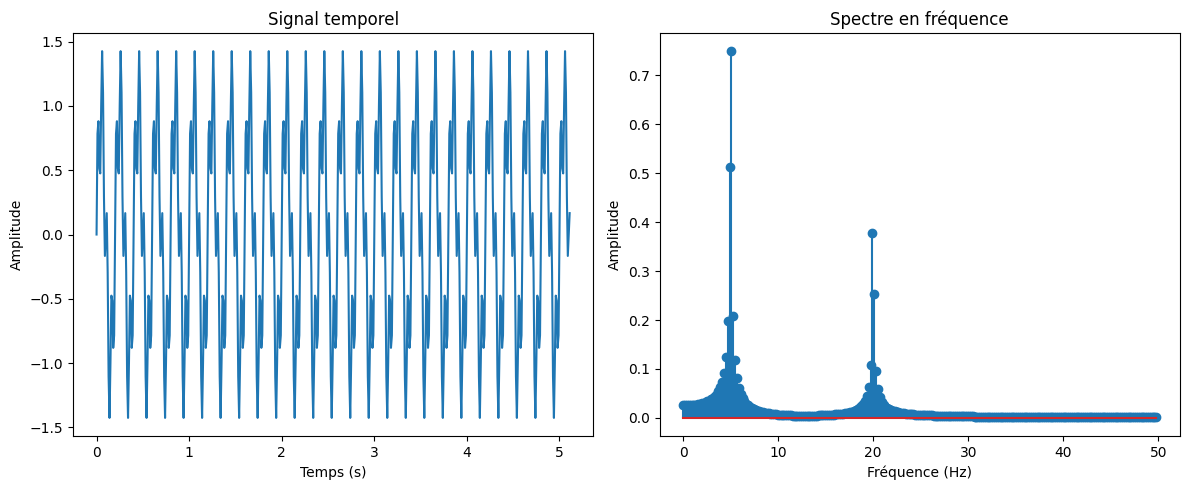

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Création d'une série temporelle ---
N = 512                 # nombre d'échantillons
T = 1.0 / 100.0         # pas d'échantillonnage (100 Hz)
t = np.linspace(0.0, N*T, N, endpoint=False)  # axe du temps

# Signal composé de deux fréquences : 5 Hz et 20 Hz
signal = np.sin(2.0*np.pi*5*t) + 0.5*np.sin(2.0*np.pi*20*t)

# --- 2. Calcul de la FFT ---
fft_values = np.fft.fft(signal)           # FFT complexe
freqs = np.fft.fftfreq(N, T)              # fréquences associées

# --- 3. Affichage ---
plt.figure(figsize=(12,5))

# Signal temporel
plt.subplot(1,2,1)
plt.plot(t, signal)
plt.title("Signal temporel")
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")

# Spectre en fréquence (module de la FFT)
plt.subplot(1,2,2)
plt.stem(freqs[:N//2], 2.0/N * np.abs(fft_values[:N//2]), use_line_collection=True)
plt.title("Spectre en fréquence")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()


# Custom Multi

In [98]:
df_raw = pd.read_csv('./dataset/ANAM/multi/Normal.csv')


In [ ]:
train = df[: int(0.7 * len(df))]
test = df[int(0.8 * len(df)) :]
val = df[int(0.7 * len(df)) : int(0.8 * len(df))]

In [105]:
train = train.values[:, 1:]

In [108]:
d = np.float32(train)
d = np.nan_to_num(d)
d

array([[1. , 0. , 0. , ..., 0. , 0. , 0. ],
       [2. , 0. , 0. , ..., 0. , 0. , 0. ],
       [3. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [4. , 0. , 0. , ..., 0. , 0. , 0. ],
       [5. , 0. , 0. , ..., 0. , 8. , 0. ],
       [6. , 4.5, 4.2, ..., 3.7, 0. , 0. ]], dtype=float32)

In [103]:
val

,station,MONTH,day_01,day_02,day_03,day_04,day_05,day_06,day_07,day_08,...,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31
515,Fada Ngourma,7,36.9,3.6,0.0,18.4,0.0,0.0,0.0,67.5,...,0.0,30.2,0.0,3.8,1.7,0.0,62.0,0.0,0.0,2.9
516,Fada Ngourma,8,3.7,0.8,0.0,0.0,4.8,15.9,1.1,0.4,...,0.0,25.1,0.0,4.0,7.0,2.1,4.7,0.0,0.0,0.0
517,Fada Ngourma,9,5.4,0.0,0.0,3.5,0.0,0.0,0.8,1.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.3,NaN
518,Fada Ngourma,10,0.0,5.6,1.7,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
519,Fada Ngourma,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584,Fada Ngourma,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
585,Boromo,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
586,Boromo,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
587,Boromo,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.1,3.4,0.0,0.0,0.0,0.0


In [104]:
test

,station,MONTH,day_01,day_02,day_03,day_04,day_05,day_06,day_07,day_08,...,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31
589,Boromo,5,0.0,0.0,21.7,1.4,0.0,0.0,0.0,0.0,...,0.7,0.0,5.6,0.0,0.0,0.0,0.0,0.0,16.4,0.0
590,Boromo,6,10.1,0.0,0.0,0.0,0.0,1.8,0.0,0.0,...,14.2,0.0,25.8,0.0,0.0,0.0,3.0,0.0,0.0,NaN
591,Boromo,7,2.4,0.0,0.0,26.2,0.0,0.0,6.6,8.2,...,0.0,0.6,0.1,0.0,23.4,0.0,44.9,0.0,0.0,0.0
592,Boromo,8,6.1,0.0,2.3,0.6,22.6,0.0,0.0,26.9,...,42.6,72.0,1.8,3.5,0.0,0.0,3.7,27.7,1.8,0.0
593,Boromo,9,38.8,0.0,0.0,2.6,0.0,0.0,18.5,26.2,...,0.0,0.0,0.0,0.0,0.0,11.2,0.0,0.0,24.9,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,Gaoua,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
733,Gaoua,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
734,Gaoua,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
735,Gaoua,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.2,0.0,3.6,1.5,0.0,0.0,0.0,0.0,0.0
